
![](https://theknclan.com/wp-content/uploads/2017/10/635980679147435890-488367249_FashionHeader.png)

# Extensive EDA of iMaterialist (Fashion) Dataset with Object Detection and Color Analysis

This notebook contains the exploration of iMaterialist Challenge (Fashion) at FGVC5 [dataset](https://www.kaggle.com/c/imaterialist-challenge-fashion-2018)

About the iMaterialist (Fashion) Competition - 

As shoppers move online, it would be a dream come true to have products in photos classified automatically. But, automatic product recognition is tough because for the same product, a picture can be taken in different lighting, angles, backgrounds, and levels of occlusion. Meanwhile different fine-grained categories may look very similar, for example, royal blue vs turquoise in color. Many of today’s general-purpose recognition machines simply cannot perceive such subtle differences between photos, yet these differences could be important for shopping decisions.

Tackling issues like this is why the Conference on Computer Vision and Pattern Recognition (CVPR) has put together a workshop specifically for data scientists focused on fine-grained visual categorization called the FGVC5 workshop. As part of this workshop, CVPR is partnering with Google, Wish, and Malong Technologies to challenge the data science community to help push the state of the art in automatic image classification.

In this competition, FGVC workshop organizers with Wish and Malong Technologies challenge you to develop algorithms that will help with an important step towards automatic product detection – to accurately assign attribute labels for fashion images. Individuals/Teams with top submissions will be invited to present their work live at the FGVC5 workshop.  




**Contents**

**1. Descriptive Statistics**   
&nbsp;&nbsp;&nbsp;&nbsp;  1.1 Counts of Images and Labels  
&nbsp;&nbsp;&nbsp;&nbsp;     1.2 Top Labels in the dataset  
&nbsp;&nbsp;&nbsp;&nbsp;     1.3 Most Common Co-occuring Labels  
&nbsp;&nbsp;&nbsp;&nbsp;     1.4 Images with maxium Labels  
&nbsp;&nbsp;&nbsp;&nbsp;     1.5 Images with single Label  
&nbsp;&nbsp;&nbsp;&nbsp;     1.6 Freq Dist of Images in different label count buckets  
**2. Colors Used in the Images**     
&nbsp;&nbsp;&nbsp;&nbsp;     2.1 Top Average Color of the images  
&nbsp;&nbsp;&nbsp;&nbsp;     2.2 Dominant Colors present in the images  
&nbsp;&nbsp;&nbsp;&nbsp;     2.3 Common Color Palletes    
**3. Object Detection**  
&nbsp;&nbsp;&nbsp;&nbsp;     3.1 Top Colors Detected in the images  
&nbsp;&nbsp;&nbsp;&nbsp;     3.2 Top Objects Detected in the images  

## Dataset Preparation 

In [1]:
from IPython.core.display import HTML
from IPython.display import Image
from collections import Counter
import pandas as pd 
import json


from plotly.offline import init_notebook_mode, iplot
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from wordcloud import WordCloud
from plotly import tools
import seaborn as sns
from PIL import Image

import tensorflow as tf
import numpy as np

init_notebook_mode(connected=True)
%matplotlib inline 

In [2]:
## read the dataset 

train_path = './imaterialist data/train.json'
test_path = './imaterialist data/test.json'
valid_path = './imaterialist data/validation.json'

train_inp = open(train_path).read()
train_inp = json.loads(train_inp)

test_inp = open(test_path).read()
test_inp = json.loads(test_inp)

valid_inp = open(valid_path).read()
valid_inp = json.loads(valid_inp)

## 1. Descriptive Statistics

## 1.1 How many Images and how many distinct labels are there in the dataset?

In [3]:
# how many images 
def get_stats(data):
    total_images = len(data['images'])

    images = data['images']
    all_annotations = []
    if 'annotations' in data:
        for each in data['annotations']:
            all_annotations.extend(each['labelId'])
    total_labels = len(set(all_annotations))
    return total_images, total_labels, all_annotations, images



In [4]:
import itertools

total_images, total_labels, train_annotations, train_images = get_stats(train_inp)
print ("Total Images in the train:", total_images)
print ("Total Labels in the train:", total_labels)
print ("train image 0", train_images[1])


Total Images in the train: 1014544
Total Labels in the train: 228
train image 0 {'url': 'https://contestimg.wish.com/api/webimage/5468f1c0d96b290ff8e5c805-large', 'imageId': '2'}


In [5]:

total_images, total_labels, test_annotations, test_images = get_stats(test_inp)
print ("Total Images in the test:", total_images)
print ("Total Labels in the test:", total_labels)
print ("")

total_images, total_labels, valid_annotations, total_images = get_stats(valid_inp)
print ("Total Images in the valid:", total_images)
print ("Total Labels in the valid:", total_labels)

Total Images in the test: 39706
Total Labels in the test: 0

Total Images in the valid: [{'url': 'https://contestimg.wish.com/api/webimage/568e16a72dfd0133cb3f7a79-large', 'imageId': '1'}, {'url': 'https://contestimg.wish.com/api/webimage/5452f9925f313f502bf119ff-large', 'imageId': '2'}, {'url': 'https://contestimg.wish.com/api/webimage/540584051d2d435c5a300a82-large', 'imageId': '3'}, {'url': 'https://contestimg.wish.com/api/webimage/540c6760f4bdc40bcc10296d-large', 'imageId': '4'}, {'url': 'https://contestimg.wish.com/api/webimage/5447777d4ad3ab71267befe2-large', 'imageId': '5'}, {'url': 'https://contestimg.wish.com/api/webimage/53d9bdaa302e550f1889f7a4-large', 'imageId': '6'}, {'url': 'https://contestimg.wish.com/api/webimage/579a47cf58c0db798a399b4a-large', 'imageId': '7'}, {'url': 'https://contestimg.wish.com/api/webimage/5671317a30a4d06e41fecd7e-large', 'imageId': '8'}, {'url': 'https://contestimg.wish.com/api/webimage/54450c9866ccaa0fae0060f5-large', 'imageId': '9'}, {'url': 'ht

There are about 1 Million images provided in the train dataset and there are 228 distinct labels which are used to label these images. There are two other sources of data as well - test data and validation data but in thie notebook I have only used images from train dataset.

## 1.2 Which are the top used Labels in the dataset ?

In [75]:
# Downloading & parsing attribute map for labels 
import pandas as pd

# Load the label map CSV
label_map_path = './imaterialist data/iMat_fashion_2018_label_map_228.csv'
label_map = pd.read_csv(label_map_path)

# Display the first few rows to understand its structure
print(label_map.head())


   labelId  taskId        labelName  taskName
0        1       6           Argyle   pattern
1        2       9       Asymmetric     style
2        3       1   Athletic Pants  category
3        4       1    Athletic Sets  category
4        5       1  Athletic Shirts  category


In [84]:
# Creating a dictionary with labelId as keys and a tuple of (labelName, taskName) as values
id_to_label_name = {row['labelId']: (row['labelName'], row['taskName']) for index, row in label_map.iterrows()}


In [85]:
# Example of accessing label info
label_id = 3
label_name, task_name = id_to_label_name[label_id]
print(f"Label ID {label_id} is for '{label_name}' which is a '{task_name}'.")


Label ID 3 is for 'Athletic Pants' which is a 'category'.


In [86]:
# Assuming id_to_label_name maps label IDs to names
label_name_to_id = {name: str(label_id) for label_id, name in id_to_label_name.items()}


In [87]:
def get_images_for_labels(labellist, data, label_name_to_id):
    # Convert label names to label IDs
    label_ids = [label_name_to_id[label] for label in labellist if label in label_name_to_id]

    image_ids = []
    for each in data['annotations']:
        # Check if all label IDs are in the current annotation's label list
        if all(label_id in each['labelId'] for label_id in label_ids):
            image_ids.append(each['imageId'])
            if len(image_ids) == 2:
                break

    image_urls = []
    for each in data['images']:
        if each['imageId'] in image_ids:
            image_urls.append(each['url'])

    return image_urls


In [88]:
# Example usage with your dataset
labellist = ['Pants', 'Pink']  # List of label names you are interested in
image_urls = get_images_for_labels(labellist, train_inp, label_name_to_id)

print(image_urls)


['https://contestimg.wish.com/api/webimage/570f35feb2f4b95d223aa9b1-large', 'https://contestimg.wish.com/api/webimage/5468f1c0d96b290ff8e5c805-large']


## 1.3 What are the most Common Co-Occuring Labels in the dataset

Since every image can be classified into multiple labels, it will be interesting to note which lables have co-occured together

In [11]:
# Most Commonly Occuring Labels 

def cartesian_reduct(alist):
    results = []
    for x in alist:
        for y in alist:
            if x == y:
                continue
            srtd = sorted([int(x),int(y)])
            srtd = " AND ".join([str(x) for x in srtd])
            results.append(srtd)
    return results 

co_occurance = []
for i, each in enumerate(train_inp['annotations']):
    prods = cartesian_reduct(each['labelId'])
    co_occurance.extend(prods)

In [12]:
coocur = Counter(co_occurance).most_common(10)
labels = list(reversed(["Label: "+str(x[0]) for x in coocur]))
values = list(reversed([x[1] for x in coocur]))

trace1 = go.Bar(x=values, y=labels, opacity=0.7, orientation="h", name="year count", marker=dict(color='rgba(130, 130, 230, 0.8)'))
layout = dict(height=400, title='Most Common Co-Occuring Labels in the dataset', legend=dict(orientation="h"));

fig = go.Figure(data=[trace1], layout=layout);
iplot(fig);

In [89]:
def get_label_description(label_id, id_to_label_name):
    """
    Retrieve the human-readable description for a given label ID.

    Args:
    label_id (int or str): The numeric ID of the label.
    id_to_label_name (dict): A dictionary mapping label IDs to their descriptions.

    Returns:
    str: The human-readable description of the label.
    """
    # Ensure label_id is converted to int if it's passed as a string
    label_id = int(label_id)
    # Return the label description if it exists, otherwise return 'Unknown label'
    return id_to_label_name.get(label_id, 'Unknown label')


In [90]:
label_id_1 = 66
description1 = get_label_description(label_id_1, id_to_label_name)

label_id_2 = 153
description2 = get_label_description(label_id_2, id_to_label_name)

label_id_3 = 171
description3 = get_label_description(label_id_1, id_to_label_name)

label_id_4 = 105
description4 = get_label_description(label_id_2, id_to_label_name)
print(f"Label IDs '{description1}' & '{description2}' used together second most.")

Label IDs '('Female', 'gender')' & '('Round Neck', 'neckline')' used together second most.


From the above graph, (label 66 and label 105) and (label 66 and label 171) have been used most number of times while labelling the images, with the total count of 460K and 445K respectively. Apart from the most frequently occuring label "66", label 105 and label 153 have been used repeatedly in the dataset.

## 1.4 Which Images are tagged with Maximum Labels

Some images are labelled with single label but some images can have labels as high as 20. Lets get the images having the largest numbers of labels in the dataset

In [15]:
def get_image_url(imgid, data):
    for each in data['images']:
        if each['imageId'] == imgid:
            return each['url']

srtedlist = sorted(train_inp['annotations'], key=lambda d: len(d['labelId']), reverse=True)

In [16]:
from IPython.display import display, HTML

def display_images_with_labels(srtedlist, train_inp, id_to_label_name):
    for img in srtedlist[:5]:
        # Retrieve the image URL
        iurl = get_image_url(img['imageId'], train_inp)

        # Convert label IDs to their human-readable descriptions
        label_descriptions = [id_to_label_name.get(int(label_id), 'Unknown label') for label_id in img['labelId']]

        # Join the descriptions into a single string
        labelpair = ", ".join(label_descriptions)

        # Create HTML content for display
        imghtml = f"Labels: {labelpair} &nbsp;&nbsp; <b>Total Labels: {len(img['labelId'])}</b><br><img src={iurl} width=200px; style='float:left'>"

        # Display the HTML
        display(HTML(imghtml))

# Example usage
display_images_with_labels(srtedlist, train_inp, id_to_label_name)


## 1.6 Frequency Distribution of Images with respective Labels Counts in the dataset

Lets visualize how many images are there in each label count bucket. 

In [17]:
lbldst = Counter([len(x['labelId']) for x in srtedlist])

labels = list(lbldst.keys())
values = list(lbldst.values())

trace1 = go.Bar(x=labels, y=values, opacity=0.7, name="year count", marker=dict(color='rgba(10, 80, 190, 0.8)'))
layout = dict(height=400, title='Frequency distribution of images with respective labels counts ', legend=dict(orientation="h"));

fig = go.Figure(data=[trace1], layout=layout);
iplot(fig);

Most of the images in the dataset have 5 or 6 labels on an average. 

## 2. Colors Used in the Images 

In the e-commerce industry, colors play a very important role in the customer behaviours. Some people are more inclined towards soft colors while some prefer warm colors. In this section, lets visualize what type of colors are used in the images. 

## 2.1 Common Average Color of the Images 

In [18]:
import urllib
from io import StringIO

def compute_average_image_color(img):
    width, height = img.size
    count, r_total, g_total, b_total = 0, 0, 0, 0
    for x in range(0, width):
        for y in range(0, height):
            r, g, b = img.getpixel((x,y))
            r_total += r
            g_total += g
            b_total += b
            count += 1
    return (r_total/count, g_total/count, b_total/count)

## 3. Object Detection using TensorFlow API 


I have used tensorflow API for object detection the code is given in the following cell.


![title](https://github.com/tensorflow/models/raw/master/research/object_detection/g3doc/img/kites_detections_output.jpg)

In [19]:
### UNCOMMENT THE FOLLOWING LINE AFTER DOWNLOADING THE UTILS FROM THIS LINK - https://github.com/tensorflow/models/tree/master/research/object_detection/utils

# from utils import label_map_util

def DOWNLOAD_MODELS():
    MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
    MODEL_FILE = MODEL_NAME + '.tar.gz'
    DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
    PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'
    PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')
    
    opener = urllib.request.URLopener()
    opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
    tar_file = tarfile.open(MODEL_FILE)
    for file in tar_file.getmembers():
        file_name = os.path.basename(file.name)
        if 'frozen_inference_graph.pb' in file_name:
            tar_file.extract(file, os.getcwd())

def detect_object(filename):

    def img2array(img):
        (img_width, img_height) = img.size
        return np.array(img.getdata()).reshape((img_width, img_height, 3)).astype(np.uint8)

    categories, probabilities = [], []
    PATH_TO_CKPT = 'frozen_inference_graph.pb'
    PATH_TO_LABELS = 'mscoco_label_map.pbtxt'
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')


    label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
    categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=100, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)

    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')

            image = Image.open(filename)
            image_np = img2array(image)
            image_np_expanded = np.expand_dims(image_np, axis=0)
            (boxes, scores, classes, num) = sess.run([detection_boxes, detection_scores, detection_classes, num_detections], feed_dict={image_tensor: image_np_expanded})
            for index,value in enumerate(classes[0]):
                if float(scores[0,index]) > 0.1:
                    temp =  category_index.get(value)['name']
                    if temp not in categories:
                        categories.append(temp)
                        probabilities.append(scores[0,index])
    return categories, probabilities


In [20]:
## UNCOMMENT THE FOLLOWING LINES TO RUN THE OBJECT DETECTION MODEL AND SAVE THE RESULTS 

# for img in srtedlist[:10]:
#     iurli = get_image_url(img['imageId'])
    
#     file = cStringIO.StringIO(urllib.urlopen(iurli).read())
#     objects = detect_object(file)

- Reference: [TensorFlow Object Detection Notebook](https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb)  
- Pre-Trained Models Reference: [PreTrained Models](https://github.com/tensorflow/models/tree/676a4f70c20020ed41b533e0c331f115eeffe9a3/research/object_detection)  
- Link to download the Utils: https://github.com/tensorflow/models/tree/master/research/object_detection/utils

In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer




In [22]:
import itertools
first_3_pairs = dict(itertools.islice(train_inp.items(), 3))

In [23]:
# Print the structure of the first few entries
print(json.dumps(first_3_pairs['images'][:3], indent=4))
print(json.dumps(first_3_pairs['annotations'][:3], indent=4))

[
    {
        "url": "https://contestimg.wish.com/api/webimage/570f35feb2f4b95d223aa9b1-large",
        "imageId": "1"
    },
    {
        "url": "https://contestimg.wish.com/api/webimage/5468f1c0d96b290ff8e5c805-large",
        "imageId": "2"
    },
    {
        "url": "https://contestimg.wish.com/api/webimage/546410237d57f323e72ca414-large",
        "imageId": "3"
    }
]
[
    {
        "labelId": [
            "95",
            "66",
            "137",
            "70",
            "20"
        ],
        "imageId": "1"
    },
    {
        "labelId": [
            "36",
            "66",
            "44",
            "214",
            "105",
            "133"
        ],
        "imageId": "2"
    },
    {
        "labelId": [
            "170",
            "66",
            "97",
            "153",
            "105",
            "138"
        ],
        "imageId": "3"
    }
]


In [24]:
# Create a dictionary to tie together the imageId with its url and labelId list
consolidated_data = {}
images_data = train_inp['images']
annotations_data= train_inp['annotations']

# Now you can print or return the consolidated data

In [25]:

for image in images_data:
    image_id = image['imageId']
    consolidated_data[image_id] = {
        'url': image['url'],
        'labelId': []
    }

for annotation in annotations_data:
    image_id = annotation['imageId']
    if image_id in consolidated_data:
        consolidated_data[image_id]['labelId'].extend(annotation['labelId'])

In [96]:
annotations_data[:5]

[{'labelId': ['95', '66', '137', '70', '20'], 'imageId': '1'},
 {'labelId': ['36', '66', '44', '214', '105', '133'], 'imageId': '2'},
 {'labelId': ['170', '66', '97', '153', '105', '138'], 'imageId': '3'},
 {'labelId': ['18', '66', '44', '153', '164'], 'imageId': '4'},
 {'labelId': ['189', '66', '176', '137', '153', '74', '181', '171', '138'],
  'imageId': '5'}]

In [26]:
def load_and_preprocess_image(file_path, labels):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [128, 128])  # Resize to the expected input size of the model
    img /= 255.0  # Normalize pixel values to [0,1]
    return img, labels 


In [27]:
# Path to your downloaded images
image_directory = "./downloaded_images"


In [28]:
import os

In [29]:
# Assuming 'consolidated_data' is already defined as your dictionary
valid_data = {
    image_id: data
    for image_id, data in consolidated_data.items()
    if os.path.exists(os.path.join(image_directory, f"{image_id}.jpg"))
}

# Now create lists of file paths and labels only for existing images
file_paths = [os.path.join(image_directory, f"{image_id}.jpg") for image_id in valid_data]
labels = [data['labelId'] for data in valid_data.values()]

In [30]:
from sklearn.preprocessing import MultiLabelBinarizer

# Assuming consolidated_data is a dictionary where each key is an image_id and each value is another dictionary with 'url' and 'labelId'
filtered_labels = {k: [label for label in v['labelId'] if label != '66'] for k, v in consolidated_data.items()}

# Create a list of labels for each image, excluding '66'
labels = [label_list for label_list in filtered_labels.values()]
# Use MultiLabelBinarizer to encode labels
mlb = MultiLabelBinarizer()
binary_labels = mlb.fit_transform(labels)


In [31]:
# Create TensorFlow datasets
path_ds = tf.data.Dataset.from_tensor_slices(file_paths)
label_ds = tf.data.Dataset.from_tensor_slices(binary_labels)
image_label_ds = tf.data.Dataset.zip((path_ds, label_ds))
image_label_ds = image_label_ds.map(load_and_preprocess_image)
image_label_ds = image_label_ds.batch(1)

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(mlb.classes_), activation='sigmoid')  # Output layer for multi-label classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/Users/anyueow/anaconda3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [33]:
# If you have a separate validation dataset, define it similarly
# Train the model
model.fit(image_label_ds, epochs=3)  # Adjust epochs according to your requirement


Epoch 1/3
277/277 ━━━━━━━━━━━━━━━━━━━━ 23s 79ms/step - accuracy: 0.1141 - loss: 0.1832
Epoch 2/3
277/277 ━━━━━━━━━━━━━━━━━━━━ 24s 88ms/step - accuracy: 0.2560 - loss: 0.0878
Epoch 3/3
277/277 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step - accuracy: 0.2437 - loss: 0.0822


In [34]:
def load_and_preprocess_image_for_prediction(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [128, 128])
    img /= 255.0
    return img


In [97]:
def predict_new_image(new_image_path, model, mlb, threshold=0.3):
    new_image = load_and_preprocess_image_for_prediction(new_image_path)
    new_image = tf.expand_dims(new_image, 0)  # Add batch dimension
    predictions = model.predict(new_image)
    predicted_labels = (predictions > threshold).astype(int)
    return mlb.inverse_transform(predicted_labels)



In [99]:
# Example usage
new_image_path = './Natalie.jpg'
predicted_labels = predict_new_image(new_image_path, model, mlb, threshold=0.2)
print(f"Predicted Labels: {predicted_labels}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Labels: [('105', '171')]


In [100]:
def translate_labels(label_codes, label_map):
    """
    Translate list of label codes to their corresponding human-readable labels.

    Args:
    label_codes (list or tuple): The list or tuple of label codes.
    label_map (dict): A dictionary mapping codes to human-readable labels.

    Returns:
    list: A list of human-readable labels.
    """
    codes = label_codes[0]
    l =[]
    for t in codes: 
        n = get_label_description(t, label_map)
        l.append(n)

    return l




In [101]:
human_readable_labels = translate_labels(predicted_labels, id_to_label_name)
print(f"Predicted Labels: {human_readable_labels}")

Predicted Labels: [('Long Sleeved', 'sleeve'), ('Sleeveless', 'sleeve')]


In [39]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('vera.keras')  # Adjust the path and file name as needed


# Looking at fashion trends 


In [40]:
import requests
from bs4 import BeautifulSoup

def fetch_image_urls(url):
    image_urls = []  # Initialize an empty list to store URLs
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        images = soup.find_all('img')
        for img in images:
            if 'src' in img.attrs:
                image_urls.append(img['src'])  # Add the URL to the list
            else:
                print("Image without a src attribute.")
        return image_urls  # Return the list of URLs
    else:
        print(f"Failed to retrieve web page content: Status code {response.status_code}")
        return []  # Return an empty list if the page could not be retrieved

# Example usage:



In [41]:
# URL of the webpage
url = "https://nowfashion.com/louis-vuitton-ready-to-wear-fall-winter-2024-paris/"
fetch_image_urls(url)

image_urls = fetch_image_urls(url)
print("Extracted Image URLs:", (image_urls[9]))

Extracted Image URLs: https://media.nowfashion.com/wp-content/uploads/2024/03/Louis-Vuitton-Ready-Wear-Fall-Winter-2024-Paris-Fashion-Week-Runway-09.jpg


We will be working with a website that regularly uploads images of runways by top designers for this season. 
Website URL: https://nowfashion.com

## Louis Vuitton

In [42]:
import os
import requests
from PIL import Image
import io

def download_images(image_urls, download_dir):
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)

    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'
    }

    total_images = len(image_urls)
    successful_downloads = 0  # Counter for successful downloads

    for i, url in enumerate(image_urls):
        try:
            response = requests.get(url, headers=headers)
            if response.status_code == 200:
                # Open the image and convert to JPEG
                image = Image.open(io.BytesIO(response.content))
                file_path = os.path.join(download_dir, f'image_{i}.jpg')
                image = image.convert('RGB')  # Convert to RGB in case it's a palette image
                image.save(file_path, 'JPEG')  # Save as JPEG
                print(f"Converted and downloaded: {file_path}")
            else:
                print(f"Failed to download {url} - Status code: {response.status_code}")
        except Exception as e:
            print(f"Failed to download or convert {url}. Error: {e}")

    print('Download and conversion completed!')

download_dir = './downloaded_images_trends_lv'
download_images(image_urls, download_dir)



Converted and downloaded: ./downloaded_images_trends_lv/image_0.jpg
Converted and downloaded: ./downloaded_images_trends_lv/image_1.jpg
Converted and downloaded: ./downloaded_images_trends_lv/image_2.jpg
Converted and downloaded: ./downloaded_images_trends_lv/image_3.jpg
Converted and downloaded: ./downloaded_images_trends_lv/image_4.jpg
Converted and downloaded: ./downloaded_images_trends_lv/image_5.jpg
Converted and downloaded: ./downloaded_images_trends_lv/image_6.jpg
Converted and downloaded: ./downloaded_images_trends_lv/image_7.jpg
Converted and downloaded: ./downloaded_images_trends_lv/image_8.jpg
Converted and downloaded: ./downloaded_images_trends_lv/image_9.jpg
Converted and downloaded: ./downloaded_images_trends_lv/image_10.jpg
Converted and downloaded: ./downloaded_images_trends_lv/image_11.jpg
Converted and downloaded: ./downloaded_images_trends_lv/image_12.jpg
Converted and downloaded: ./downloaded_images_trends_lv/image_13.jpg
Converted and downloaded: ./downloaded_image

In [43]:
def load_and_preprocess_image_for_prediction(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)  # This handles various formats
    img = tf.image.resize(img, [128, 128])  # Resize to the model's expected input size
    img /= 255.0  # Normalize pixel values to [0,1]
    
    return img

In [44]:

def predict_labels_for_images(download_dir, model):
    predicted_labels = []
    for filename in os.listdir(download_dir):
        if filename.endswith(".jpg"):
            file_path = os.path.join(download_dir, filename)
            image = load_and_preprocess_image_for_prediction(file_path)
            image = tf.expand_dims(image, 0)  # Add batch dimension
            predictions = model.predict(image)
            label_indices = np.where(predictions[0] > 0.3)[0]  # Threshold for prediction
            print(label_indices)
        predicted_labels.append(label_indices) 
    return predicted_labels



In [45]:
def convert_to_labels(label_arrays, label_dict):
    from itertools import chain

    # Convert each index to its corresponding label using the label dictionary
    all_labels = [label_dict.get(index, "Unknown") for array in label_arrays for index in array]

    return all_labels

def find_trending_label(all_labels):
    from collections import Counter

    # Count the occurrences of each label
    label_counts = Counter(all_labels)

    # Find the label with the highest count
    trending_label = label_counts.most_common(1)[0]

    return trending_label, label_counts


In [46]:
predicted_labels = predict_labels_for_images(download_dir, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[7]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[7]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[80]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[7]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[80]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[7]
1/1 ━━━━

In [47]:
# Convert indices to labels
lv_labels = convert_to_labels(predicted_labels, id_to_label_name)
print("All Labels:", lv_labels)


All Labels: ['Backless Dresses', 'Backless Dresses', 'Halter Tops', 'Backless Dresses', 'Halter Tops', 'Backless Dresses', 'Halter Tops', 'Backless Dresses', 'Halter Tops', 'Backless Dresses', 'Backless Dresses', 'Backless Dresses', 'Backless Dresses', 'Halter Tops', 'Halter Tops', 'Backless Dresses', 'Halter Tops', 'Asymmetric', 'Backless Dresses', 'Baggy Jeans', 'Beaded', 'Binders', 'Blouses', 'Bubble Coats', 'Cardigans', 'Casual Dresses', 'Casual Shorts', 'Checkered', 'Chevron', 'Cleats', 'Corduroy', 'Criss Cross', 'Crop Tops', 'Dance Wear', 'Drawstring Pants', 'Dress Shirts', 'Dresses', 'Fringe', 'Galaxy', 'Gray', 'Halter Tops', 'Hi-Lo', 'Hosiery, Stockings, Tights', 'Houndstooth', 'Jackets', 'Jilbaab', 'Kimonos', 'Leggings', 'Multi Color', 'Neoprene', 'Organza', 'Peplum', 'Pink', 'Plaid', 'Polyester', 'Prom Dresses', 'Quilted', 'Reversible', 'Satin', 'Silk', 'Slippers', 'Spaghetti Straps', 'Spandex', 'Sports Bras', 'Stilettos', 'Suits & Blazers', 'Sweetheart Neckline', 'Swim Trunk

In [48]:
trending = []
for l in lv_labels:
    
    trending.append(l)
    
print(trending)

['Backless Dresses', 'Backless Dresses', 'Halter Tops', 'Backless Dresses', 'Halter Tops', 'Backless Dresses', 'Halter Tops', 'Backless Dresses', 'Halter Tops', 'Backless Dresses', 'Backless Dresses', 'Backless Dresses', 'Backless Dresses', 'Halter Tops', 'Halter Tops', 'Backless Dresses', 'Halter Tops', 'Asymmetric', 'Backless Dresses', 'Baggy Jeans', 'Beaded', 'Binders', 'Blouses', 'Bubble Coats', 'Cardigans', 'Casual Dresses', 'Casual Shorts', 'Checkered', 'Chevron', 'Cleats', 'Corduroy', 'Criss Cross', 'Crop Tops', 'Dance Wear', 'Drawstring Pants', 'Dress Shirts', 'Dresses', 'Fringe', 'Galaxy', 'Gray', 'Halter Tops', 'Hi-Lo', 'Hosiery, Stockings, Tights', 'Houndstooth', 'Jackets', 'Jilbaab', 'Kimonos', 'Leggings', 'Multi Color', 'Neoprene', 'Organza', 'Peplum', 'Pink', 'Plaid', 'Polyester', 'Prom Dresses', 'Quilted', 'Reversible', 'Satin', 'Silk', 'Slippers', 'Spaghetti Straps', 'Spandex', 'Sports Bras', 'Stilettos', 'Suits & Blazers', 'Sweetheart Neckline', 'Swim Trunks', 'Tank To

## Trying for Vivian Tam 

In [49]:

url_vt = "https://nowfashion.com/acne-studios-ready-to-wear-fall-winter-2024-paris-2/"
image_urls_vt = fetch_image_urls(url_vt)

In [50]:
download_dir_vt = './downloaded_images_trends_vt'
download_images(image_urls_vt, download_dir_vt)


Converted and downloaded: ./downloaded_images_trends_vt/image_0.jpg
Converted and downloaded: ./downloaded_images_trends_vt/image_1.jpg
Converted and downloaded: ./downloaded_images_trends_vt/image_2.jpg
Converted and downloaded: ./downloaded_images_trends_vt/image_3.jpg
Converted and downloaded: ./downloaded_images_trends_vt/image_4.jpg
Converted and downloaded: ./downloaded_images_trends_vt/image_5.jpg
Converted and downloaded: ./downloaded_images_trends_vt/image_6.jpg
Converted and downloaded: ./downloaded_images_trends_vt/image_7.jpg
Converted and downloaded: ./downloaded_images_trends_vt/image_8.jpg
Converted and downloaded: ./downloaded_images_trends_vt/image_9.jpg
Converted and downloaded: ./downloaded_images_trends_vt/image_10.jpg
Converted and downloaded: ./downloaded_images_trends_vt/image_11.jpg
Converted and downloaded: ./downloaded_images_trends_vt/image_12.jpg
Converted and downloaded: ./downloaded_images_trends_vt/image_13.jpg
Converted and downloaded: ./downloaded_image

In [51]:

def predict_labels_for_images_vt(download_dir, model):
    predicted_labels = []
    for filename in os.listdir(download_dir):
        if filename.endswith(".jpg"):
            file_path = os.path.join(download_dir, filename)
            image = load_and_preprocess_image_for_prediction(file_path)
            image = tf.expand_dims(image, 0)  # Add batch dimension
            predictions = model.predict(image)
            label_indices = np.where(predictions[0] > 0.5)[0]  # Threshold for prediction
            print(label_indices)
        predicted_labels.append(label_indices)
    return predicted_labels

predicted_labels_vt = predict_labels_for_images_vt(download_dir_vt, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[]
1/1 ━━━━━━━━━━━━

In [52]:
vt_labels = convert_to_labels(predicted_labels, id_to_label_name)
print("Human-readable labels:", vt_labels)

Human-readable labels: ['Backless Dresses', 'Backless Dresses', 'Halter Tops', 'Backless Dresses', 'Halter Tops', 'Backless Dresses', 'Halter Tops', 'Backless Dresses', 'Halter Tops', 'Backless Dresses', 'Backless Dresses', 'Backless Dresses', 'Backless Dresses', 'Halter Tops', 'Halter Tops', 'Backless Dresses', 'Halter Tops', 'Asymmetric', 'Backless Dresses', 'Baggy Jeans', 'Beaded', 'Binders', 'Blouses', 'Bubble Coats', 'Cardigans', 'Casual Dresses', 'Casual Shorts', 'Checkered', 'Chevron', 'Cleats', 'Corduroy', 'Criss Cross', 'Crop Tops', 'Dance Wear', 'Drawstring Pants', 'Dress Shirts', 'Dresses', 'Fringe', 'Galaxy', 'Gray', 'Halter Tops', 'Hi-Lo', 'Hosiery, Stockings, Tights', 'Houndstooth', 'Jackets', 'Jilbaab', 'Kimonos', 'Leggings', 'Multi Color', 'Neoprene', 'Organza', 'Peplum', 'Pink', 'Plaid', 'Polyester', 'Prom Dresses', 'Quilted', 'Reversible', 'Satin', 'Silk', 'Slippers', 'Spaghetti Straps', 'Spandex', 'Sports Bras', 'Stilettos', 'Suits & Blazers', 'Sweetheart Neckline', 

In [53]:

for l in vt_labels:
    
    trending.append(l)
    
print(trending)

['Backless Dresses', 'Backless Dresses', 'Halter Tops', 'Backless Dresses', 'Halter Tops', 'Backless Dresses', 'Halter Tops', 'Backless Dresses', 'Halter Tops', 'Backless Dresses', 'Backless Dresses', 'Backless Dresses', 'Backless Dresses', 'Halter Tops', 'Halter Tops', 'Backless Dresses', 'Halter Tops', 'Asymmetric', 'Backless Dresses', 'Baggy Jeans', 'Beaded', 'Binders', 'Blouses', 'Bubble Coats', 'Cardigans', 'Casual Dresses', 'Casual Shorts', 'Checkered', 'Chevron', 'Cleats', 'Corduroy', 'Criss Cross', 'Crop Tops', 'Dance Wear', 'Drawstring Pants', 'Dress Shirts', 'Dresses', 'Fringe', 'Galaxy', 'Gray', 'Halter Tops', 'Hi-Lo', 'Hosiery, Stockings, Tights', 'Houndstooth', 'Jackets', 'Jilbaab', 'Kimonos', 'Leggings', 'Multi Color', 'Neoprene', 'Organza', 'Peplum', 'Pink', 'Plaid', 'Polyester', 'Prom Dresses', 'Quilted', 'Reversible', 'Satin', 'Silk', 'Slippers', 'Spaghetti Straps', 'Spandex', 'Sports Bras', 'Stilettos', 'Suits & Blazers', 'Sweetheart Neckline', 'Swim Trunks', 'Tank To

## Chanel Analysis 

In [54]:
# https://nowfashion.com/chanel-ready-to-wear-fall-winter-2024-paris/#google_vignette

In [55]:

url_ch = "https://nowfashion.com/chanel-ready-to-wear-fall-winter-2024-paris/#google_vignette"
image_urls_ch = fetch_image_urls(url_ch)

In [56]:
download_dir_ch = './downloaded_images_trends_ch'
download_images(image_urls_vt, download_dir_ch)


Converted and downloaded: ./downloaded_images_trends_ch/image_0.jpg
Converted and downloaded: ./downloaded_images_trends_ch/image_1.jpg
Converted and downloaded: ./downloaded_images_trends_ch/image_2.jpg
Converted and downloaded: ./downloaded_images_trends_ch/image_3.jpg
Converted and downloaded: ./downloaded_images_trends_ch/image_4.jpg
Converted and downloaded: ./downloaded_images_trends_ch/image_5.jpg
Converted and downloaded: ./downloaded_images_trends_ch/image_6.jpg
Converted and downloaded: ./downloaded_images_trends_ch/image_7.jpg
Converted and downloaded: ./downloaded_images_trends_ch/image_8.jpg
Converted and downloaded: ./downloaded_images_trends_ch/image_9.jpg
Converted and downloaded: ./downloaded_images_trends_ch/image_10.jpg
Converted and downloaded: ./downloaded_images_trends_ch/image_11.jpg
Converted and downloaded: ./downloaded_images_trends_ch/image_12.jpg
Converted and downloaded: ./downloaded_images_trends_ch/image_13.jpg
Converted and downloaded: ./downloaded_image

In [57]:
predicted_labels_ch = predict_labels_for_images(download_dir_vt, model)
print(len(predicted_labels_ch))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[7]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[7]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[7]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[7]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[80]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[]
1/1 ━━━━━━

In [58]:
ch_labels = convert_to_labels(predicted_labels_ch, id_to_label_name)
print("Human-readable labels:", ch_labels)

#trending.append(ch_labels)


Human-readable labels: ['Backless Dresses', 'Backless Dresses', 'Backless Dresses', 'Backless Dresses', 'Halter Tops', 'Backless Dresses', 'Backless Dresses', 'Backless Dresses', 'Halter Tops', 'Backless Dresses', 'Asymmetric', 'Backless Dresses', 'Baggy Jeans', 'Beaded', 'Binders', 'Blouses', 'Bubble Coats', 'Cardigans', 'Casual Dresses', 'Casual Shorts', 'Checkered', 'Chevron', 'Cleats', 'Corduroy', 'Criss Cross', 'Crop Tops', 'Dance Wear', 'Drawstring Pants', 'Dress Shirts', 'Dresses', 'Fringe', 'Galaxy', 'Gray', 'Halter Tops', 'Hi-Lo', 'Hosiery, Stockings, Tights', 'Houndstooth', 'Jackets', 'Jilbaab', 'Kimonos', 'Leggings', 'Multi Color', 'Neoprene', 'Organza', 'Peplum', 'Pink', 'Plaid', 'Polyester', 'Prom Dresses', 'Quilted', 'Reversible', 'Satin', 'Silk', 'Slippers', 'Spaghetti Straps', 'Spandex', 'Sports Bras', 'Stilettos', 'Suits & Blazers', 'Sweetheart Neckline', 'Swim Trunks', 'Tank Tops', 'Teal', 'Thermal Underwear', 'Tie Dye', 'Tulle', 'Tunic', 'Vintage Retro', 'Winter Boot

In [59]:

for l in ch_labels:
    
    trending.append(l)
    
print(trending)

['Backless Dresses', 'Backless Dresses', 'Halter Tops', 'Backless Dresses', 'Halter Tops', 'Backless Dresses', 'Halter Tops', 'Backless Dresses', 'Halter Tops', 'Backless Dresses', 'Backless Dresses', 'Backless Dresses', 'Backless Dresses', 'Halter Tops', 'Halter Tops', 'Backless Dresses', 'Halter Tops', 'Asymmetric', 'Backless Dresses', 'Baggy Jeans', 'Beaded', 'Binders', 'Blouses', 'Bubble Coats', 'Cardigans', 'Casual Dresses', 'Casual Shorts', 'Checkered', 'Chevron', 'Cleats', 'Corduroy', 'Criss Cross', 'Crop Tops', 'Dance Wear', 'Drawstring Pants', 'Dress Shirts', 'Dresses', 'Fringe', 'Galaxy', 'Gray', 'Halter Tops', 'Hi-Lo', 'Hosiery, Stockings, Tights', 'Houndstooth', 'Jackets', 'Jilbaab', 'Kimonos', 'Leggings', 'Multi Color', 'Neoprene', 'Organza', 'Peplum', 'Pink', 'Plaid', 'Polyester', 'Prom Dresses', 'Quilted', 'Reversible', 'Satin', 'Silk', 'Slippers', 'Spaghetti Straps', 'Spandex', 'Sports Bras', 'Stilettos', 'Suits & Blazers', 'Sweetheart Neckline', 'Swim Trunks', 'Tank To

In [60]:
from collections import Counter

# Count occurrences of each unique element
counts = Counter(trending)

# Extract unique elements and their counts
unique_elements = list(counts.keys())
counts_values = list(counts.values())


In [61]:
trends = {}

for items in vt_labels: 
    trends[items] = vt_labels.count(items)


In [68]:
print(trends)

{'Backless Dresses': 23, 'Halter Tops': 11, 'Asymmetric': 1, 'Baggy Jeans': 1, 'Beaded': 1, 'Binders': 1, 'Blouses': 1, 'Bubble Coats': 1, 'Cardigans': 1, 'Casual Dresses': 1, 'Casual Shorts': 1, 'Checkered': 1, 'Chevron': 1, 'Cleats': 1, 'Corduroy': 1, 'Criss Cross': 1, 'Crop Tops': 1, 'Dance Wear': 1, 'Drawstring Pants': 1, 'Dress Shirts': 1, 'Dresses': 1, 'Fringe': 1, 'Galaxy': 1, 'Gray': 1, 'Hi-Lo': 1, 'Hosiery, Stockings, Tights': 1, 'Houndstooth': 1, 'Jackets': 1, 'Jilbaab': 1, 'Kimonos': 1, 'Leggings': 1, 'Multi Color': 1, 'Neoprene': 1, 'Organza': 1, 'Peplum': 1, 'Pink': 1, 'Plaid': 1, 'Polyester': 1, 'Prom Dresses': 1, 'Quilted': 1, 'Reversible': 1, 'Satin': 1, 'Silk': 1, 'Slippers': 1, 'Spaghetti Straps': 1, 'Spandex': 1, 'Sports Bras': 1, 'Stilettos': 1, 'Suits & Blazers': 1, 'Sweetheart Neckline': 1, 'Swim Trunks': 1, 'Tank Tops': 1, 'Teal': 1, 'Thermal Underwear': 1, 'Tie Dye': 1, 'Tulle': 1, 'Tunic': 1, 'Vintage Retro': 1, 'Winter Boots': 1, 'Wool': 1, 'Wrap': 1}


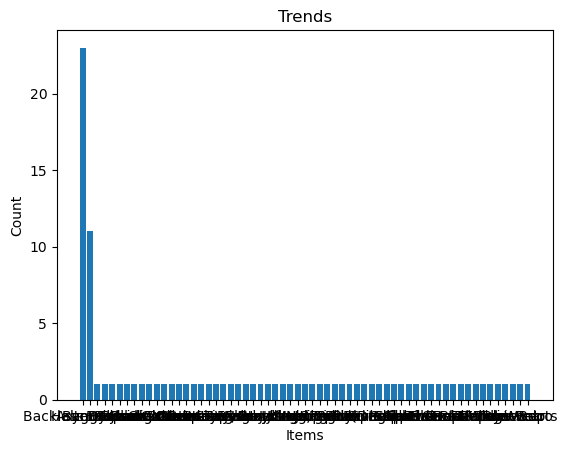

In [62]:
# Plotting the bar chart
plt.bar(trends.keys(), trends.values())
plt.xlabel('Items')
plt.ylabel('Count')
plt.title('Trends')
plt.show()

In [63]:
# Find the top 5 values and their corresponding names
top_5_values = sorted(trends.values(), reverse=True)[:5]
top_5_names = [key for key, value in trends.items() if value in top_5_values]

print("Top 5 values and their corresponding names:")
for value, name in zip(top_5_values, top_5_names):
    print(f"{name}: {value}")
top_trends = dict(Counter(trends).most_common(5))


Top 5 values and their corresponding names:
Backless Dresses: 23
Halter Tops: 11
Asymmetric: 1
Baggy Jeans: 1
Beaded: 1


In [64]:
import plotly.graph_objects as go

# Create a bar chart
#fig = go.Figure([go.Bar(x=list(top_trends.keys()), y=list(top_trends.values()))])

# Customize layout
#fig.update_layout(
   # title='Top 5 Fashion Item Trends',
    #xaxis_title='Items',
    #yaxis_title='Count',
    #template='plotly_dark'  # Optional: use a template
#)

In [65]:
# Live Demo
new_image_path = './manvi.jpg'
predicted_labels_try = predict_new_image(new_image_path, model, mlb, threshold=0.12)
print(f"Predicted Labels: {predicted_labels_try}")

human_readable_labels = translate_labels(predicted_labels_try, id_to_label_name)
print(f"Predicted Labels: {human_readable_labels}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Predicted Labels: [('105', '106', '153', '171')]
Predicted Labels: ['Long Sleeved', 'Male', 'Round Neck', 'Sleeveless']
